Estudio de Prophet

In [28]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt


dfVentas = pd.read_csv('ventas.csv')
dfVentas.head()

,Cantidad (en UM de inventario),VentaNeta,CodCliente,Número de documento,ItemCode,CodVendedor,Código de almacén de línea,Fecha,Descripción del artículo,CanalDeVenta,Kilombos
0,30,58172.0,C77196968,1054011,100401405101,11,B30,5-Apr-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,6.0
1,60,116345.0,C76047944,1065766,100401405101,4,B30,11-Aug-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,12.0
2,60,116344.0,C76047944,1071927,100401405101,4,B30,20-Oct-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,12.0
3,60,116345.0,T00000581,1044987,100401405101,38,B30,3-Nov-20,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,12.0
4,60,116345.0,T00000377,1055172,100401405101,38,B30,21-Apr-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,12.0


In [3]:
cranberriesItems = [140201405101, 140202405101, 140101110103, 140101110104, 140201408102, 140201409102, 140202408102, 140202409101, 140203409101]
cranberriesDf = dfVentas[dfVentas['ItemCode'].isin(cranberriesItems)]

In [6]:
cranberriesDf['Descripción del artículo'].value_counts()

Cranberry Entero  Cubierta Chocolate Bitter Bl. 5Kg       1318
Cranberry Cubierta Chocolate Leche Bl. 5Kg                 657
Cranberry Entero  Cubierta Chocolate Bitter Bl.200 Gr.     105
Cranberry Cubierta Chocolate Leche Bl. 200 Gr.              74
Cranberry Entero  Cubierta Chocolate Bitter Bl. 1Kg          1
Name: Descripción del artículo, dtype: int64

In [7]:
columns_hash = {
    'Cantidad (en UM de inventario)': 'cantidad',
    'VentaNeta': 'venta_total',
    'CodCliente': 'cod_cliente',
    'Número de documento': 'n_boleta',
    'ItemCode': 'item_code',
    'CodVendedor': 'cod_vendedor',
    'Código de almacén de línea': 'cod_almacen',
    'Fecha': 'fecha',
    'Descripción del artículo': 'descripcion',
    'CanalDeVenta': 'canal_venta',
    'Kilombos': 'kilombos',
}
# Renombrar las columnas
cranberriesDf = cranberriesDf.rename(columns=columns_hash)
cranberriesDf.head(5)

,cantidad,venta_total,cod_cliente,n_boleta,item_code,cod_vendedor,cod_almacen,fecha,descripcion,canal_venta,kilombos
1988,30,51677.98322,C76825371,1055564,140202405101,4,B30,27-Apr-21,Cranberry Cubierta Chocolate Leche Bl. 200 Gr.,Televenta,6.0
1989,30,51618.00000,C76047944,1042002,140202405101,4,B30,11-Sep-20,Cranberry Cubierta Chocolate Leche Bl. 200 Gr.,Televenta,6.0
1990,30,51618.00000,C76047944,1044398,140202405101,4,B30,23-Oct-20,Cranberry Cubierta Chocolate Leche Bl. 200 Gr.,Televenta,6.0
1991,30,51618.00000,C76047944,1045289,140202405101,4,B30,6-Nov-20,Cranberry Cubierta Chocolate Leche Bl. 200 Gr.,Televenta,6.0
1992,30,51618.00000,C76116617,1051111,140202405101,4,B30,11-Feb-21,Cranberry Cubierta Chocolate Leche Bl. 200 Gr.,Televenta,6.0


In [19]:
# Función para convertir fecha ''
def convert_date(date):
    return pd.to_datetime(date, format='%d-%b-%y')
cranberriesDf['ds'] = cranberriesDf['fecha'].apply(convert_date).sort_values(ascending=True)

In [22]:
grouped = cranberriesDf.groupby('ds').agg({'kilombos': 'sum', 'venta_total': 'sum', 'cod_cliente': 'nunique', 'cod_vendedor': 'nunique'})
grouped.shape

(474, 4)

In [53]:
grouped.head(5)

,kilombos,venta_total,cod_cliente,cod_vendedor
ds,,,,
2019-04-02,40.0,254117.0,1,1
2019-04-05,5.0,35294.0,1,1
2019-04-30,5.0,35714.0,1,1
2019-05-02,5.0,39900.0,2,2
2019-05-03,15.0,107143.0,2,1


In [54]:
prophetDf = grouped.reset_index().rename(columns={'kilombos': 'y'}).drop(columns=['venta_total', 'cod_cliente', 'cod_vendedor'])
# prophetDf['cap'] = 150
m = Prophet().add_country_holidays(country_name='CL')
m.fit(prophetDf)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


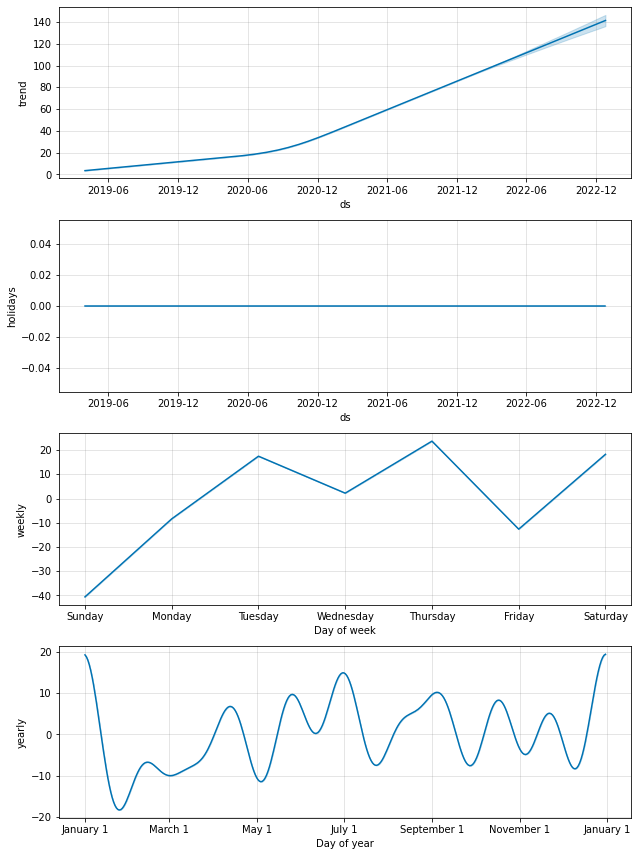

In [57]:
future = m.make_future_dataframe(periods=56, freq='W')
# future['cap'] = 300
forecast = m.predict(future)
fig1 = m.plot_components(forecast)
